In [ ]:
#!git clone https://github.com/neuralcomputer/ML_School.git

# Тема № 26. Поиск гиперпараметров
У моделей, которые мы обучаем, есть набор гиперпараметров, которые мы должны задавать сами, и не можем получить их из данных. Например число кластеров для метода К-средних, вид функции ядра для машин опорных векторов и подобные. 

Но как узнать, какие гиперпараметры лучше брать?

Увы, на такой вопрос нет ответа, в большинстве случаев нельзя заранее знать какой гиперпараметр будет лучше, более того, мы даже не можем сказать какая модель лучше. Нам остается только два варианта: 
- выбирать их интуитивно исходя из нашего опыта, изучения литературы или похожих задач
- перебирать всевозможные значения гиперпараметров и искать наилучшие.

В первом варианте компьютер нам не поможет, а во втором может помочь - пусть компьютер сам перебирает варианты и ищет подходящие нам!

Для этого в модуле [`model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)библиотеки `sklearn` реализованы функции 
- [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), поиск по сетке, которая пребирает все комбинации гиперпараметров из заданных значений и сравнивает модели по заданной метрике, 
- [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV), случайный поиск, которая случайно выбирает комбинации гиперпараметров и сравнивает модели по заданной метрике.

Синтаксис их похож, мы должны указать аргументы:
* `estimator` - модель для которой будем искать гиперпараметры
* `scoring` - название метрики для сравнения (если `None` то будет использован метод `score()` модели)
* `param_grid` для `GridSearchCV` или `param_distributions` для `RandomizedSearchCV` - словарь из названий гиперпараметров и их проверяемых значений или вида распределения для `RandomizedSearchCV`
* `n_iter` для `RandomizedSearchCV` - число проверяемых комбинаций гиперпараметров (у `GridSearchCV` проверяются все комбинации)
* и др.

После обучения эти объекты имеют атрибуты:
* `cv_results_` - словарь, с названиями и значениями результатов, включая статистику по величине `score` и времени выполнения.
* `best_estimator_` - лучшая модель с найденными гиперпараметрами 
* `best_score_` - средне значение `score` для лучшей модели
* `best_params_` - гиперпараметры лучшей модели
* и другие

Методы такие же как и у моделей, из них работают только те, которые у модели есть. Модель обязана иметь методы `fit` и `score`, остальные (`predict`, `predict_proba`, `decision_function`, `transform`, `inverse_transform`)  используются если есть .

Давайте посмотрим на пример и сравним эти две функции. Набритесь терпения, перебор долгий процесс.

In [ ]:
import numpy as np #
from time import time # для замеров времени
import scipy.stats as stats # для задания равномерного распределения
from sklearn.utils.fixes import loguniform # для задания лог-равномерного распределения

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # методы поиска гиперпараметров
from sklearn.datasets import load_digits # набор данных
from sklearn.linear_model import SGDClassifier # линейный классификатор

# загружаем данные
X, y = load_digits(return_X_y=True)

# создаем модель классификатора
clf = SGDClassifier(loss='hinge', penalty='elasticnet',
                    fit_intercept=True)


# функция для отображения результатов
def report(results, n_top=3): # принимает результаты cv_results_ и число рангов модели
    for i in range(1, n_top + 1): # ранг модели с 1 до n_top + 1 (1 ранг - лучшая модель)
        candidates = np.flatnonzero(results['rank_test_score'] == i) # выбираем результаты для модели текущего ранга
        for candidate in candidates: # перебираем все результаты для нее и выводим на экран 
            print("Model with rank: {0}".format(i)) # ранг
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate], # среднее значение результата на тесте
                          results['std_test_score'][candidate])) # дисперсия результатов на тесте
            print("Parameters: {0}".format(results['params'][candidate])) # значения параметров для этой модели
            print("")

# СЛУЧАЙНЫЙ ПОИСК
# задаем гиперпараметры и их значения или распределения (см. описание гиперпараметров для этой модели)
param_dist = {'average': [True, False], # усреднять \ не усреднять
              'l1_ratio': stats.uniform(0, 1), # коэффициент члена нормализации берется из равномерного распределения от 0 до 1
              'alpha': loguniform(1e-4, 1e0)} # коэффициент альфа берется из лог-равномерного распределения от 0.0001 до 1 

# 
n_iter_search = 20 # число комбинаций гиперпараметров
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, #
                                   n_iter=n_iter_search) # создаем поиск

start = time() # запускаем таймер
random_search.fit(X, y) # обучаем модель с поиском гиперпараметров
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search)) # выводим время обучения и число итераций 
report(random_search.cv_results_) # выводим результаты

# ПОИСК ПО СЕТКЕ
# задаем (те же) гиперпараметры и их конкретные значения (см. описание гиперпараметров для этой модели)
param_grid = {'average': [True, False], #
              'l1_ratio': np.linspace(0, 1, num=10), # от 0 до 1 10 шутк
              'alpha': np.power(10, np.arange(-4, 1, dtype=float))} # от 0.0001 до 1 степень 10ки


grid_search = GridSearchCV(clf, param_grid=param_grid) #  создаем поиск
start = time() # запускаем таймер
grid_search.fit(X, y) # обучаем модель с поиском гиперпараметров

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params']))) # выводим время обучения и число итераций #
report(grid_search.cv_results_) # выводим результаты

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


RandomizedSearchCV took 28.82 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.930 (std: 0.029)
Parameters: {'alpha': 0.00011742261219037211, 'average': True, 'l1_ratio': 0.6466961245681951}

Model with rank: 2
Mean validation score: 0.926 (std: 0.027)
Parameters: {'alpha': 0.000531026342394059, 'average': True, 'l1_ratio': 0.14987524544483333}

Model with rank: 3
Mean validation score: 0.926 (std: 0.027)
Parameters: {'alpha': 0.5727124250161993, 'average': False, 'l1_ratio': 0.022344162516640176}



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV took 134.80 seconds for 100 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.929 (std: 0.024)
Parameters: {'alpha': 0.0001, 'average': True, 'l1_ratio': 0.4444444444444444}

Model with rank: 2
Mean validation score: 0.928 (std: 0.027)
Parameters: {'alpha': 0.0001, 'average': True, 'l1_ratio': 0.0}

Model with rank: 3
Mean validation score: 0.928 (std: 0.029)
Parameters: {'alpha': 0.001, 'average': True, 'l1_ratio': 0.0}



Придумайте и назовите два недостатка каждого из подходов - поиска по сетке и случайного поиска.

# Сравнение классификаторов

Мы познакомились с малой частью моделей машинного обучения.

Машинное обучение это не только наука, но и искусство, многое решает ваша интуиция, но так же много зависит и от математической и инженерной подготовки. Это постоянные исследования, сравнения, выбор и модификация решений, причем совершенно в разных плоскостях. Можно бесконечно усложнять и искать подходящие гиперпараметры модели, но она никак не заработает, а можно сменить набор собираемых данных и получить решение простой моделью, или наоборот, для данных которые на первый взгляд кажутся простыми, придется построить сложную модель.

Качество работы модели это совокупная оценка, а не одна величина, мы уже познакомились с некоторыми метриками качества, но следует отметить и другие:

  * время выполнения и обучения модели - очень важный критерий, часто решающий, и выгодней сделать более простую, но менее точную модель, зато решать будет быстрее.
  * возможность применения параллельных вычислителей. Сегодня компьютеры состоят из множества одновременно работающих процессоров (или ядер процессоров), и важно, чтобы алгоритмы модели могли задействовать все эти устройства, чтобы не было простоя. Не для всех алгоритмов такое возможно.

Разработка моделей это постоянные исследования и сравнения, давайте сравним несколько классификаторов между собой. Создадим данные, проведем предобработку, обучим модели и отобразим результаты. Мы используем какие в голову придут классификаторы из тех, что есть в библиотеке sklearn, добавьте\замените их своими, попробуйте разные гиперпараметры.


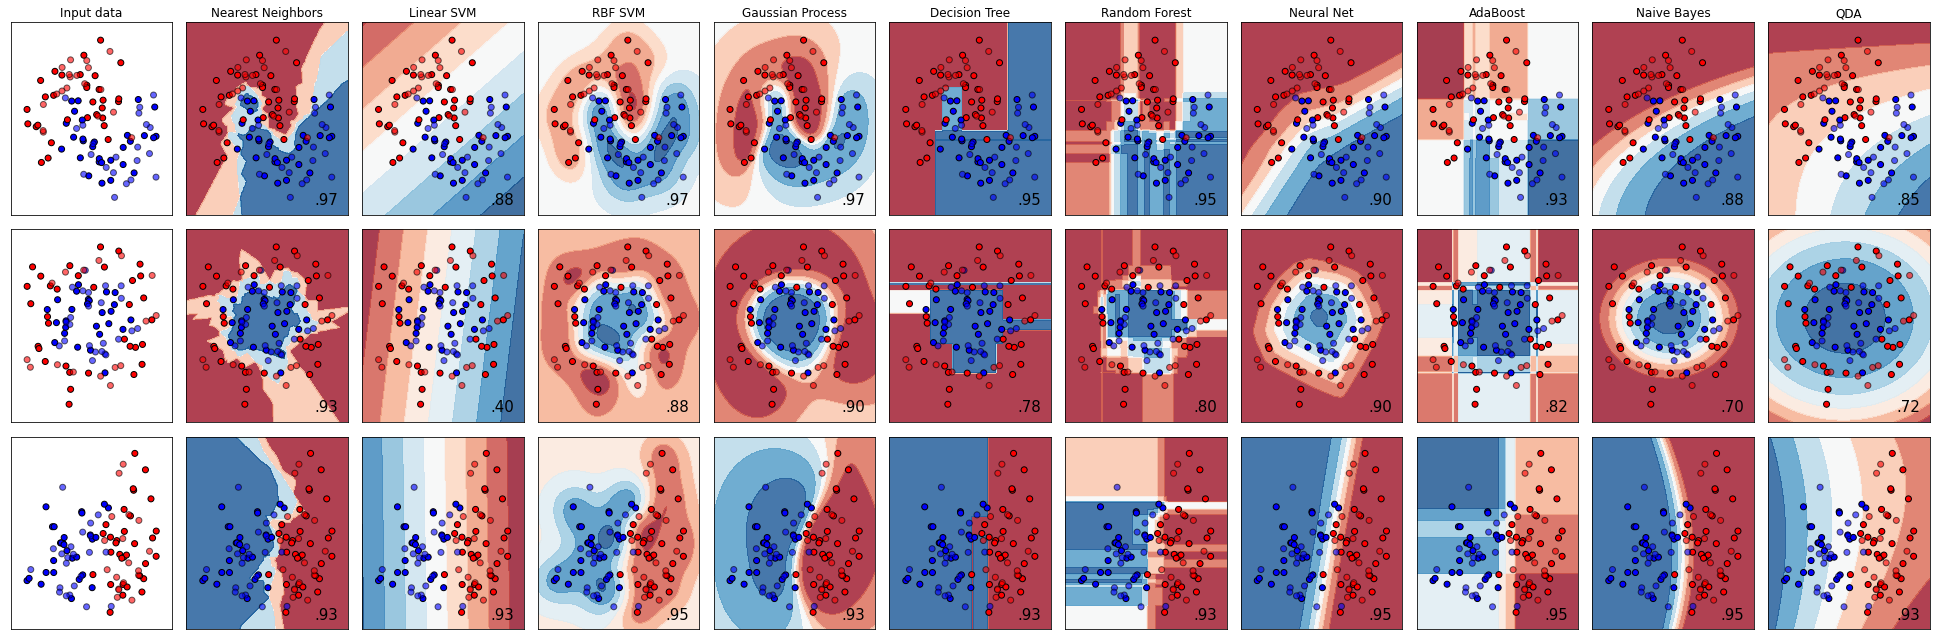

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap # цвета для графиков
from sklearn.model_selection import train_test_split # разделение на обучение и тест
from sklearn.preprocessing import StandardScaler # для масштабирования
from sklearn.datasets import make_moons, make_circles, make_classification # некоторые генераторы наглядных данных
from sklearn.neural_network import MLPClassifier # нейронная сеть (еще не проходили, но использовать лекго)
from sklearn.neighbors import KNeighborsClassifier # ближайшие соседи
from sklearn.svm import SVC # машина опорных векторов
from sklearn.gaussian_process import GaussianProcessClassifier # еще какая-то модель 
from sklearn.gaussian_process.kernels import RBF # и еще
from sklearn.tree import DecisionTreeClassifier # дерево
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier # случайный лес и бустинг
from sklearn.naive_bayes import GaussianNB # наивный Байес
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # еще одна не известная нам модель... их много
# добавьте свои модели

h = .02  # шаг для сетки проверки и рисования
# названия моделей
names = [
    "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
    "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "Naive Bayes",
    "QDA"
]

# инициализируем классификаторы
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

# генерируем данные - три набора точек двух классов на плоскости
# третий набор - два кластера
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)

rng = np.random.RandomState(2) #

X += 2 * rng.uniform(size=X.shape) # шум

linearly_separable = (X, y) #
# три набора
datasets = [make_moons(noise=0.3, random_state=0), # первый - две пересекающиеся полуокружности 
            make_circles(noise=0.2, factor=0.5, random_state=1),# второй - две вложенные окружности
            linearly_separable # третий - два овальных кластера
            ]

# обучаем классификаторы на данных и отображаем результаты.

figure = plt.figure(figsize=(27, 9)) # 
i = 1 # номер подграфика
# цикл по количеству наборов данных
for ds_cnt, ds in enumerate(datasets):
    # предобработка
    X, y = ds # разделяем входы и указания учителя
    X = StandardScaler().fit_transform(X) # масштабируем входы
    # разделяем на обучение и тест
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42) #
    # сетка для теста, чуть больше чем минимальные\максимальные значения входов
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # по одной оси
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # по другой оси
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), # создаем сетку
                         np.arange(y_min, y_max, h)) #

    # рисуем наборы данных
    cm = plt.cm.RdBu # цветовая схема
    cm_bright = ListedColormap(['#FF0000', '#0000FF']) # вот эти цвета возьмем
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i) # подграфик для рисования
    if ds_cnt == 0: # для первого
        ax.set_title("Input data") # подписываем заголовок 
    # рисуем обучающие точки
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # рисуем тестовые точки с прозрачностью
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max()) # область отображения по х
    ax.set_ylim(yy.min(), yy.max()) # область отображения по у 
    ax.set_xticks(()) # убираем деления осей по х
    ax.set_yticks(()) # убираем деления осей по у
    i += 1 # номер следующего подграфика

    # цикл по классификаторам
    for name, clf in zip(names, classifiers): #
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i) # текущий подграфик
        clf.fit(X_train, y_train) # обучаем классификатор
        score = clf.score(X_test, y_test) # считаем его score на тесте

        # считаем разделяющую поверхность
        if hasattr(clf, "decision_function"): # если у классификатора есть метод decision_function
            # то его и используем
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) #
        else: # а если нет
            # то считаем через predict_proba()
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] #

        # рисуем разделяющую поверхность
        Z = Z.reshape(xx.shape) # собираем обратно в матрицу
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8) # рисуем, полупрозрачно

        # рисуем обучающие точки 
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        #  рисуем тестовые точки 
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0: # для первой строки подграфиков
            ax.set_title(name) # подписываем заголовок 
        # добавляем на график текст с величиной score 
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1 # номер следующего подграфика
        
plt.tight_layout() # более компактное расположение подграфиков
plt.show() # отображаем на экране

Даже на этих простых данных, как мы видим, нельзя сказать что одна модель всегда лучше другой: для одних данных лучше одни модели, для других - другие. 